<a href="https://colab.research.google.com/github/dhruvmalik007/wiki_preci_demo/blob/main/Topoi_agent_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Topoi Discussion agent tutorial


This is the tutorial for the researchers to try to come up with a discussion quorum agent that



In [1]:
## installing the required libraries

!pip install langchain_community langchain_openai langchain langgraph langchain_experimental wikipedia langchain-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 3.4

In [ ]:
## also fetching the env vars for accessing the openai / tavily or other services
from google.colab import userdata
import os

os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [ ]:

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import wikipedia
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_openai import OpenAI
from langchain.agents import load_tools, AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, ToolMessage, HumanMessage, ChatMessage
from langchain_core.prompts.chat import MessagesPlaceholder, ChatPromptTemplate
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
import functools
from langgraph.graph import END, StateGraph
from typing import Sequence, TypedDict, Annotated
import operator
import os
import getpass
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper




In [ ]:
## making huggingface endpoint function in order to call freely available server inferrencing alternatives
from langchain_huggingface import HuggingFaceEndpoint
from langchain.agents import tool

huggingfacellm = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
    task="text-generation",
    max_new_tokens=1000,
    do_sample=False,
)

@tool
def get_huggingface_invokation(query):
  return huggingfacellm.invoke(query)



In [ ]:
## adding langchain memory functions in order to excute the agent operations with memory.





In [ ]:

def scraping_agent(llm, tools, system_message: str):
  """
  define the agent specialised with the addressing queries with context related to the wikipedia
  """
  topoi_categories = ["Comparison", "Cause & Effect", "Logical", "Ethical", "Slippery Slope", "Appeal to Authority", "Appeal to Emotion"]

  prompt = ChatPromptTemplate.from_messages(
      [
          (
              "system",
              "You are helpful AI assistant specilizing in constructing arguments as topoi and collaborating with other assistants "
              "Use the provided tools to progress towards responding to the given topoi, or giving contradiction provided by another."
              "you always need to cite the statistics with clear references and dont repeat the discussions on other topics"
              "try to give as many hypothesis to support your response (at least 3) on each topic with reason"
              "You will be provided with the topic : {topoi_category},"
              "dont deviate much your answer around the topic and be precise"
              "you will have to organise discussion for a topoi between assistant for 5 rounds checking the discussions of your corresponding researcher/ critic agent collague "
              "AND MOST IMP:  Use as much facts from the news sources (WITH NUMBERS) as possible"
              "prefix your response with FINAL ANSWER so all the subordinate teaam discussing with you knows when to stop after the 3 round discussion and shift to next discussion."
              "You have access to the following tools: {tool_names}.\n{system_message}",
          ),
          MessagesPlaceholder(variable_name="messages"),
      ]
  )
  prompt = prompt.partial(system_message=system_message)
  prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]), topoi_category=",".join([_topoi for _topoi in topoi_categories]))
  return prompt | llm.bind_tools(tools)



def wikipedia_result(query):
  wikipediaQuery = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
  return wikipediaQuery.run(query)





In [ ]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)


In [ ]:
## creating the agent operation

import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


In [ ]:
import functools

from langchain_core.messages import AIMessage
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

llm = ChatOpenAI(model="gpt-4-1106-preview")

wikipediaTools = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

# Research agent and node
research_agent = scraping_agent(
    llm,
    [tavily_tool],

    system_message="You should provide the accurate topoi responses based on the given topic and your subordinate discussion.",
)

research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")



# chart_generator
chart_agent = scraping_agent(
    llm,
    [wikipediaTools],
    system_message="the responses that you generate visible to the user with that of researcher.",
)
critic_node = functools.partial(agent_node, agent=chart_agent, name="critic_node")



In [ ]:
## defining the supervisor node that will be managing the running of the subordinate nodes
from langgraph.prebuilt import ToolNode
from typing import Literal

tools = [tavily_tool, wikipediaTools]
supervisor_node = ToolNode(tools)


#  Here Either agent can decide to end based on their topoi result
# but both will be synchronously generating the result for the specific topoi topic argument at same time

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"


In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("critic_node", critic_node)
workflow.add_node("call_tool", supervisor_node)

workflow.add_conditional_edges(
   "Researcher",
    router,
    {"continue": "critic_node", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "critic_node",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)


workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "critic_node": "critic_node",
    },
)


workflow.set_entry_point("Researcher")
graph = workflow.compile()










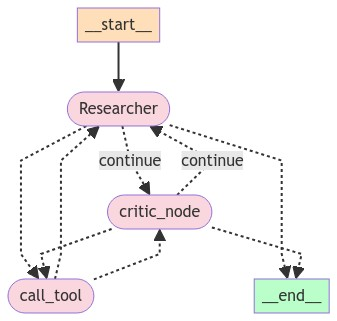

In [ ]:
## showcasing the workflow of the graph:


from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [ ]:
## now finally invoking the function on a specific query



events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Construct and debate the various category of topoi argument"
                "on the topic: Israel and hamas war and how the israel's legitimate right of defense is countered by palestinians accusation of genocide?"

            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 400},
)
for s in events:
    print(s)
    print("----")


{'Researcher': {'messages': [AIMessage(content="To engage in this debate, we will consider various categories of topoi arguments to analyze the topic: the conflict between Israel and Hamas, focusing on Israel's claim to a legitimate right of defense versus Palestinian accusations of genocide. The categories will include Comparison, Cause & Effect, Logical, Ethical, Slippery Slope, Appeal to Authority, and Appeal to Emotion.\n\nROUND 1: INITIATING DISCUSSION\n\n1. Comparison:\nHypothesis: The situation between Israel and Hamas can be compared to other international conflicts where a state asserts its right to self-defense.\nReason: Similar to how other nations respond to threats, Israel claims the right to defend its citizens against Hamas's rocket attacks. Conversely, Palestinians compare their plight to historical instances of oppression and systemic violence.\n\n2. Cause & Effect:\nHypothesis: Israel's military actions lead to Palestinian casualties, which are then framed as genocide